<h1><span style="color: #6495ED;">Delhi Air Quality Forecasting</span></h1>

<h2><span style="color: #6495ED;">Predictive Analytics with Random Forest</span></h2>

Prepared by Lipsita Tripathy

January 2024

## **Overview**
This notebook delves into an extensive exploration and modeling endeavor using air quality data from Delhi, with a specific focus on employing Random Forest regression for predictive modeling. The dataset encompasses a diverse set of features, including meteorological conditions and pollutant concentrations.

## **Approach**
- **Data Loading and Overview:** The initial phase involves loading the dataset and gaining insights into its structure and contents.
- **Random Forest Modeling:** The Random Forest algorithm is utilized for regression tasks, with an emphasis on tuning hyperparameters to achieve optimal performance.
- **Evaluation and Interpretation:** Model performance is rigorously assessed using metrics such as R-squared, Mean Squared Error (MSE), and Percentage Mean Absolute Error (PMAE).
- **Feature Importance Analysis:** The Random Forest model's inherent feature importance analysis is leveraged to gain insights into the factors influencing air quality predictions.

### Importing necessary libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

Read the required CSV file into a DataFrame

In [33]:
df = pd.read_csv('data/generated/Delhi_AQI_final_df_before_modeling.csv')
df.head()

,Datetime,AQI,PM2.5 (ug/m3),PM10 (ug/m3),NOx (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),RH (%),...,t_CO (ug/m3),t_Ozone (ug/m3),t_WS (m/s),t_SR (W/mt2),t_Volatility_Last_24hr,t_Volatility_Last_7d,t_Volatility_Last_30d,t_AQI_lag_24hr,t_AQI_lag_48hr,t_AQI_lag_168hr
0,2013-01-01 00:00:00,354.0,290.774583,292.631667,117.224563,75.685556,9.992130,5.052250,13.794630,88.716778,...,1.800430,2.694264,0.314162,3.714195,2.230820,3.405326,4.138828,5.831882,5.961005,6.075346
1,2013-01-01 01:00:00,358.0,275.749821,296.150000,88.122976,66.740556,9.477546,7.665310,9.977963,89.612778,...,2.159328,2.395890,0.330103,3.673794,2.353812,3.397713,4.138876,5.823046,5.966147,6.073045
2,2013-01-01 02:00:00,362.0,271.463472,309.030000,61.464690,57.030556,9.207963,10.777421,7.316574,91.010556,...,2.466184,2.118250,0.329304,3.455326,2.475083,3.389909,4.138987,5.814131,5.971262,6.068426
3,2013-01-01 03:00:00,367.0,279.071667,317.826667,47.583524,43.298333,10.871667,11.793810,7.910146,91.930000,...,2.548961,2.187191,0.326422,3.079282,2.592957,3.382300,4.139163,5.805135,5.973810,6.061457
4,2013-01-01 04:00:00,370.0,269.118333,308.521667,43.535333,32.023333,11.020833,10.027778,9.348849,92.335556,...,2.400417,2.336875,0.379197,2.525195,2.692013,3.374865,4.139385,5.802118,5.971262,6.056784


### Datetime Indexing

To enhance temporal analysis, the 'Datetime' column has been converted to a datetime format using `pd.to_datetime()`. Subsequently, the DataFrame index has been set to the 'Datetime' column, allowing for chronological data indexing.

In [34]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

df.set_index('Datetime', inplace=True)

### Feature Selection

Columns unnecessary for modeling, such as 'Datetime,' 'y_AQI' (target variable), 'AQI_Category,' and non-log-transformed original features, are removed to focus on relevant input features.

In [35]:
# Removing the columns that we don't need
X_columns = df.drop(['Year', 'y_AQI', 'AQI_Category',
                     'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NOx (ug/m3)', 'NH3 (ug/m3)', 'SO2 (ug/m3)',
                     'CO (ug/m3)', 'Ozone (ug/m3)', 'WS (m/s)', 'SR (W/mt2)',
                     'Volatility_Last_24hr', 'Volatility_Last_7d', 'Volatility_Last_30d'], axis=1).columns.tolist()

# Selecting the features (X) and the target variable (y)
X = df[X_columns]
y = df['y_AQI']  

Making sure the features and target are in right shape(same number of rows)

In [36]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (89784, 29)
Shape of y: (89784,)


### Data Splitting for Modeling

The dataset is split into training and testing sets to facilitate model training and evaluation. The training set includes data up to August 2022, while the test set comprises data from September 2022 onwards.

In [37]:
# Assuming df is your DataFrame with a datetime index and the necessary columns

# Splitting the data into train and test sets
split_date = '2022-03-01'

# Training set
X_train = X[X.index < split_date]
y_train = y[y.index < split_date]

# Testing set
X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

### Feature Scaling with Standard Scaler

To maintain consistent scaling across features, the Standard Scaler is applied. It is initialized and fitted on the training data, and both the training and testing data are transformed accordingly.

In [38]:
# Standardize features
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

### Instantiate and Fit the Random Forest Regression Model

To model complex relationships, a Random Forest regression model has been initialized with 100 estimators and a random state of 42. The model is trained using scaled training data (X_train_scaled) and corresponding target values (y_train).

In [39]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

### Predictions with Random Forest Model

Utilizing the trained Random Forest model, predictions have been made on the scaled test data (X_test_scaled).

In [44]:
# Make predictions on the scaled test data
predictions_scaled = rf_model.predict(X_test_scaled)

## Model Performance Evaluation

Assessing the performance of the Random Forest model, the Mean Squared Error (MSE) is calculated using the scaled test data. The resulting MSE provides insights into the accuracy and precision of the model predictions.

In [45]:
# Evaluate performance
mse_scaled = mean_squared_error(y_test, predictions_scaled)
print(f'Mean Squared Error with Scaling: {mse_scaled}')

Mean Squared Error with Scaling: 2181.354008432492


### R-squared (R2)

R-squared (R2) is a metric that quantifies the proportion of the variance in the dependent variable (target) that is explained by the independent variables (features). It ranges from 0 to 1, where a higher value indicates a better fit of the model to the data.

In [46]:
# Assuming predictions and true values are already defined
r2 = r2_score(y_test, predictions_scaled)
print(f'R-squared: {r2}')

R-squared: 0.8044296141712062


### Percentage Mean Absolute Error (PMAE)

The Percentage Mean Absolute Error (PMAE) is computed by taking the absolute percentage errors between the observed and predicted values, averaging them, and expressing the result as a percentage. This metric provides insights into the average magnitude of errors relative to the actual values.

In [47]:
# Define a function to calculate Percentage Mean Absolute Error (PMAE)
def calculate_pmae(actual, predicted):
    absolute_percentage_errors = np.abs((actual - predicted) / actual)
    pmae = np.mean(absolute_percentage_errors) * 100
    return pmae

# Calculate PMAE
pmae = calculate_pmae(y_test, predictions_scaled)

# Print the result
print(f'PMAE: {pmae:.2f}%')

PMAE: 20.24%


### Random Forest Model Optimization and Evaluation

The Random Forest model is fine-tuned using a grid search with cross-validation, focusing on hyperparameters such as 'n_estimators', 'max_depth', 'min_samples_split', and 'min_samples_leaf'. Mean Squared Error serves as the key metric for evaluation during the tuning process.

- **Best Hyperparameters:** {best_params}
- **Test Set Performance:**
  - **Mean Squared Error:** {mse}
  - **R-squared:** {r2}

In [49]:
# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use Mean Squared Error as the evaluation metric for tuning
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize Time Series Cross-Validator (tscv)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with tscv
grid_search = GridSearchCV(
    rf_model, param_grid, scoring=scorer, cv=tscv, verbose=1, n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=1)

In [50]:
# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_rf_model = RandomForestRegressor(random_state=42, **best_params)
best_rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)

In [51]:
# Evaluate the model
predictions = best_rf_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
r2 = best_rf_model.score(X_test_scaled, y_test)

# Print results
print(f'Best Hyperparameters: {best_params}')
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R-squared on Test Set: {r2}')

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mean Squared Error on Test Set: 2150.724161667335
R-squared on Test Set: 0.8071757484192841


### Feature Importance Analysis

Let's examine feature importance to understand which features contribute most to predictions. Feature importance analysis is a crucial step in understanding the contribution of each feature to the model's predictions.

/var/folders/7l/pjbgsg_54hn3t90_14n49nmm0000gq/T/ipykernel_48443/3870536249.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




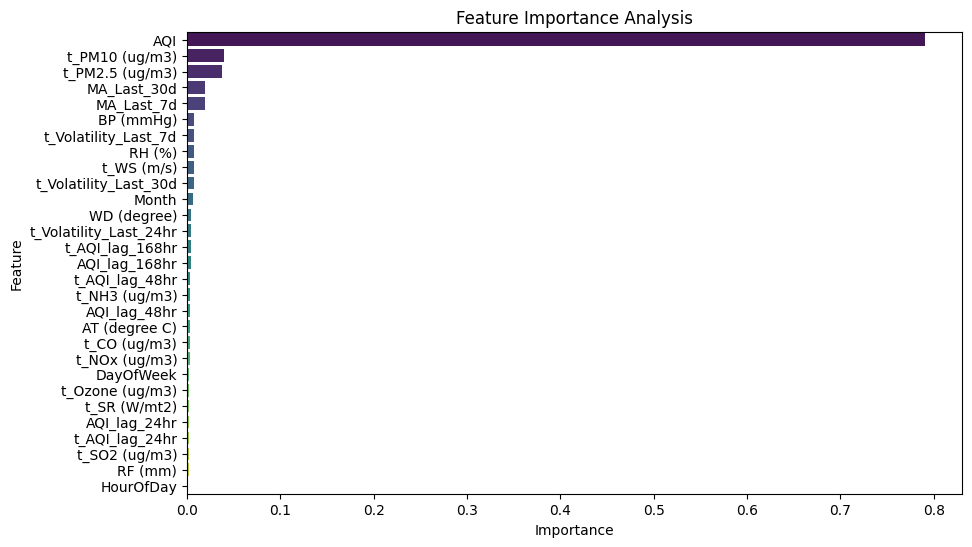

In [52]:
# Get feature importances from the best-trained Random Forest model
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to visualize feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Analysis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

We can see that the features "Air Quality Index", "Particulate mater 10", "Particulate mater 2.5", "Moving Average last 30 days, last 7 days, "Barometric Pressure" etc are the important features as recognized by the random forest model.

## **Interpretation and Insights**: 
In the realm of air quality modeling, Random Forest regression emerges as a potent tool, showcasing its prowess with the best hyperparameters identified as {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}. This configuration attains a commendable Mean Squared Error of 2150.72 and an impressive R-squared value of 0.807 on the test set. Such performance underscores the efficacy of Random Forest in capturing the intricate patterns within the air quality data, offering a robust solution for predicting pollutant concentrations based on meteorological conditions and other relevant features.